In [52]:
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import normalize
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import matplotlib.pyplot as plt
from glob import glob
import os
import random
import numpy as np

In [2]:
model_20221030 = load_model('../Trained_models/20221030_atherosclerosis_model.h5')

In [3]:
SIZE_X = 544
SIZE_Y = 544
n_classes = 4

In [4]:
input_dir = "../Dataset/images/"
mask_dir = "../Dataset/labels/"

train_images = []
for directory_path in glob(input_dir):
    for img_path in glob(os.path.join(directory_path, "*.png")):
        img = cv2.imread(img_path, 0)
        train_images.append(img)
        
train_images = np.array(train_images)

train_masks = []
for directory_path in glob(mask_dir):
    for mask_path in glob(os.path.join(directory_path, "*.png")):
        mask = cv2.imread(mask_path, 0)
        train_masks.append(mask)

train_masks = np.array(train_masks)

In [9]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_reshaped_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_reshaped_encoded_original_shape)

/Users/davidpilny/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3])

In [15]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

train_masks_input = np.expand_dims(train_masks, axis=3)

X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state=42)

train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

print("Class values in the dataset are ...", np.unique(y_train))

Class values in the dataset are ... [0 1 2 3]


In [16]:
y_pred = model_20221030.predict(X_test)

2023-03-31 19:36:14.253886: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-03-31 19:36:14.254589: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [43]:
predictions = np.argmax(y_pred, axis=3)

In [45]:
y_test = np.squeeze(y_test, axis=(3,))

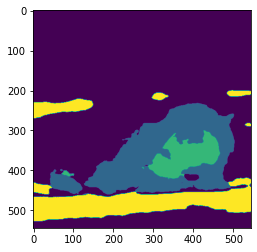

In [26]:
plt.imshow(predictions[0])

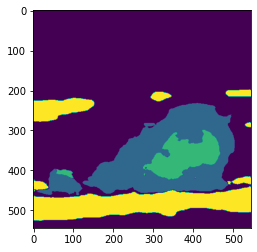

In [27]:
plt.imshow(y_test[0])

In [51]:
cf_matrix = multilabel_confusion_matrix(y_test[0], predictions[0])

ValueError: unknown is not supported

In [58]:
metrics.accuracy_score(y_test.reshape(-1), predictions.reshape(-1))

0.9740388105039176

In [56]:
np.unique(predictions)

array([0, 1, 2, 3])

In [59]:
from tensorflow.keras.metrics import MeanIoU

In [81]:
num_classes = 4
IOU = MeanIoU(num_classes=num_classes)
IOU.update_state(y_test, predictions)

<tf.Variable 'UnreadVariable' shape=(4, 4) dtype=float32, numpy=
array([[1.6777216e+07, 6.0567000e+04, 1.0008000e+04, 9.3595000e+04],
       [6.8708000e+04, 2.1953480e+06, 1.0012000e+04, 1.5433000e+04],
       [1.0693000e+04, 3.8815000e+04, 3.5475100e+05, 3.9000000e+01],
       [3.3759900e+05, 2.2938000e+04, 1.0000000e+00, 4.0569870e+06]],
      dtype=float32)>

In [82]:
values = np.array(IOU.get_weights()).reshape(num_classes, num_classes).astype(int)

<AxesSubplot:>

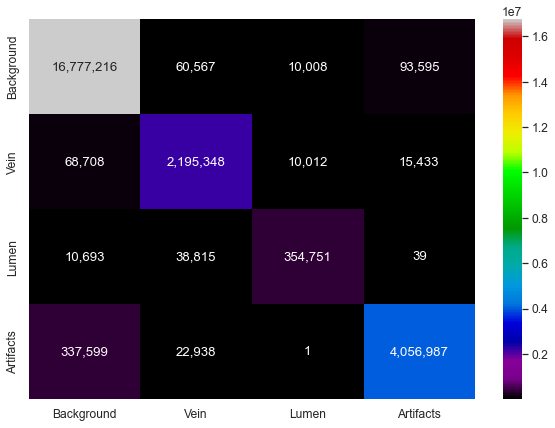

In [107]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(values, index = ['Background', 'Vein', 'Lumen', 'Artifacts'],
                  columns = ['Background', 'Vein', 'Lumen', 'Artifacts'])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt=',d', cmap='nipy_spectral') 

In [80]:
values

array([[196946,   1407,     31,   1233],
       [  2081,  43201,     25,    296],
       [   320,    984,  11752,      0],
       [  4365,     48,      0,  33247]])

In [84]:
df_cm

,1,2,3,4
1,16777216,60567,10008,93595
2,68708,2195348,10012,15433
3,10693,38815,354751,39
4,337599,22938,1,4056987
